# Vlerick use case : optimizing distribution policies

Presenting Proximus Ada's use case for the Vlerick hackcathon - 2024/04

--- 

## Imports

Public

In [1]:
import os
import io
import sys
import glob
import copy
import warnings
import statistics
from datetime import timedelta

import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

Local

In [2]:
from custom_objects import *

In [3]:
a=1

In [4]:
!pwd

/home/jovyan/vlerick


## Data

Reading basetable

In [5]:
df = pd.read_pickle('/home/jovyan/vlerick/vlerick.pkl')

In [6]:
df.index.levels[-1].freq = 'D'

## The problem

* There are a few materials

In [7]:
materials = df.index.levels[0].unique().tolist()
materials

[62003310,
 64639795,
 64639981,
 64639984,
 64639988,
 64640000,
 64640153,
 64640219,
 64641022]

In [8]:
material = 64640153 # 'Random' selection of a material for vizualization purposes

* That are sold in quite a number of shops

In [9]:
df.index.levels[1].unique().tolist()

['B124',
 'B238',
 'B319',
 'B420',
 'B534',
 'B536',
 'T101',
 'T102',
 'T103',
 'T105',
 'T107',
 'T110',
 'T111',
 'T113',
 'T114',
 'T115',
 'T120',
 'T125',
 'T126',
 'T127',
 'T128',
 'T129',
 'T146',
 'T149',
 'T201',
 'T202',
 'T204',
 'T205',
 'T206',
 'T207',
 'T209',
 'T210',
 'T213',
 'T215',
 'T216',
 'T220',
 'T223',
 'T232',
 'T233',
 'T234',
 'T237',
 'T238',
 'T301',
 'T302',
 'T303',
 'T304',
 'T305',
 'T311',
 'T315',
 'T316',
 'T317',
 'T318',
 'T325',
 'T348',
 'T403',
 'T407',
 'T410',
 'T411',
 'T412',
 'T413',
 'T415',
 'T504',
 'T507',
 'T508',
 'T509',
 'T510',
 'T513',
 'T517',
 'T518',
 'T520',
 'T527',
 'T529',
 'T531',
 'T724',
 'T734',
 'T743',
 'T751',
 'T753',
 'T754',
 'T760',
 'T772',
 'T780',
 'T782',
 'T790',
 'T791',
 'T792',
 'T794',
 'T942']

* Over a given period of time

In [10]:
df.index.levels[-1].unique()

DatetimeIndex(['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04',
               '2023-09-05', '2023-09-06', '2023-09-07', '2023-09-08',
               '2023-09-09', '2023-09-10',
               ...
               '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-23',
               '2024-03-24', '2024-03-25', '2024-03-26', '2024-03-27',
               '2024-03-28', '2024-03-29'],
              dtype='datetime64[ns]', name='Date', length=211, freq='D')

* Consequently, as suspected, we have data points per material-shop-day combinations

In [11]:
df.index

MultiIndex([(62003310, 'B124', '2023-09-12'),
            (62003310, 'B124', '2023-09-13'),
            (62003310, 'B124', '2023-09-14'),
            (62003310, 'B124', '2023-09-15'),
            (62003310, 'B124', '2023-09-16'),
            (62003310, 'B124', '2023-09-17'),
            (62003310, 'B124', '2023-09-18'),
            (62003310, 'B124', '2023-09-19'),
            (62003310, 'B124', '2023-09-20'),
            (62003310, 'B124', '2023-09-21'),
            ...
            (64641022, 'T942', '2024-03-20'),
            (64641022, 'T942', '2024-03-21'),
            (64641022, 'T942', '2024-03-22'),
            (64641022, 'T942', '2024-03-23'),
            (64641022, 'T942', '2024-03-24'),
            (64641022, 'T942', '2024-03-25'),
            (64641022, 'T942', '2024-03-26'),
            (64641022, 'T942', '2024-03-27'),
            (64641022, 'T942', '2024-03-28'),
            (64641022, 'T942', '2024-03-29')],
           names=['Material', 'Plant', 'Date'], length=154179)

* There are 13 available variables...

In [12]:
df.iloc[0]

Description               DBramante recycled Magsafe cover Monaco - blac...
Type                                                        Accessories A&C
Supply                                                                  363
Demand                                                                    0
Price                                                                 29.99
Status                                                     Ready for Launch
Current_month_forecast                                                  250
Daily_forecast                                                          0.1
Hist_method                                                           NEVER
Hist_activity                                                         21.31
Hist_shop_stock                                                           0
Hist_supplier_stock                                                     350
Hist_sales                                                                0
Name: (62003

* Of which __supply__ and __demand__ play a predominant role (more info on the other variables at the end)

    * Each MATERIAL has specific supply increases that are sent to the central warehouse

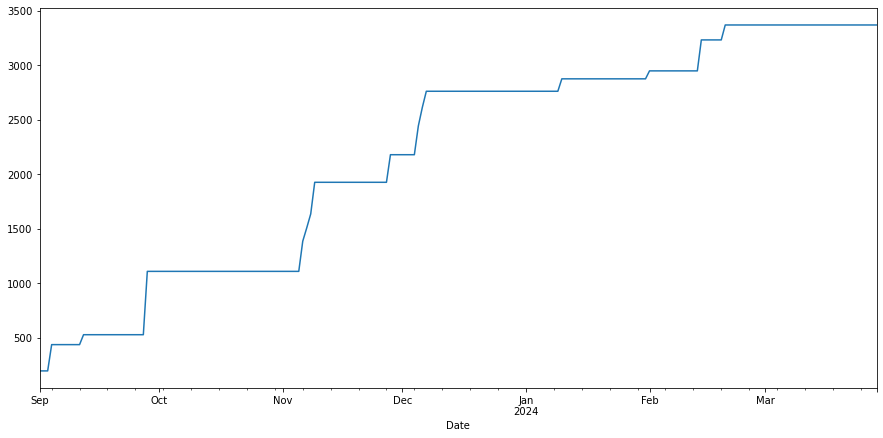

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
df.loc[material].Supply.groupby(level=-1).first().cumsum().plot()

    * And for each MATERIAL and SHOP, there's a specific demand

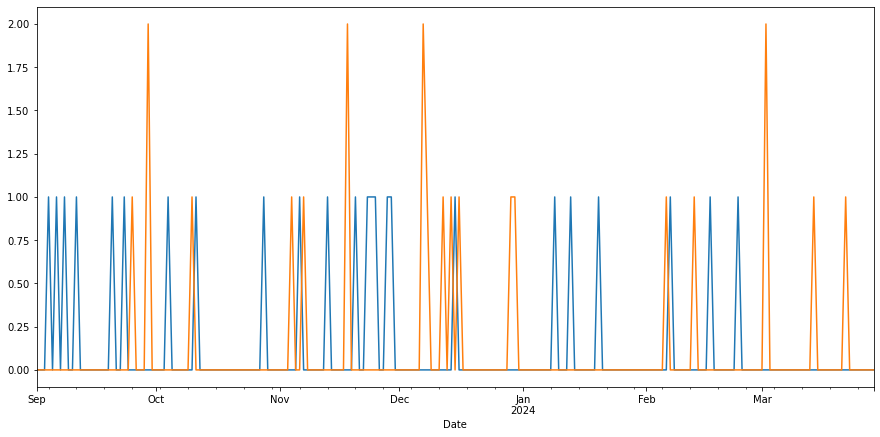

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))
df.loc[material].loc['B124'].Demand.plot()
df.loc[material].loc['T942'].Demand.plot()

* There are costs incurred for:

    * Every unit of unmet demand

In [15]:
UNDERSTOCK_COST

250

    * Every unit of unsold stock still remaining in shop

In [16]:
OVERSTOCK_COST

0.05

    * Every unit of end-of-life overstock

In [17]:
TERMINAL_COST

180

__>>> MAIN RESEARCH QUESTION__:
> Given the fact that orders are delivered after a 2 day lead time, what is the strategy that will minimize these costs?

## The tools

The `MPInvManagementEnv` will help you validate your assumptions by simulating your delivery strategy per material over all shops. It will automatically take into account above mentioned costs.

> __Tip__: don't hesitate to have a look at the object's docstrings, to get a full view of the available attributes for example .

In [18]:
help(MPInvManagementEnv)

Help on class MPInvManagementEnv in module custom_objects:

class MPInvManagementEnv(gym.core.Env)
 |  MPInvManagementEnv(demand_dist: Union[dict, pandas.core.frame.DataFrame], supply_dist: Union[dict, pandas.core.series.Series], init_inv: Union[dict, int] = 0, lead_time: Union[dict, int] = 2, resupply_first: bool = True, overstock_cost: Union[int, float] = 0.05, understock_cost: Union[int, float] = 250, terminal_cost: Union[int, float] = 180, transformer: Union[Callable, NoneType] = None, observer: Union[Callable, NoneType] = None, reset: bool = True) -> None
 |  
 |  Multi Plant Inventory Management Environment.
 |  
 |  Args:
 |      demand_dist: The distribution of demands over time per plant.
 |      supply_dist: The distribution of supply increases over time.
 |      init_inv: The initial inventory level.
 |      lead_time: The time in days between order placement and delivery. Can be a mapping for each plant; Which itself
 |                 can be a mapping for each weekday.
 | 

Using it, requires minor processing of our `df`. We do this on a slice of our previously selected material.

In [19]:
# df_material[df_material.Status=='Maturity'].Date

In [20]:
material=64640153
dist_dict = dist_df_to_dict(df.loc[material][['Demand', 'Supply']])

__The environment allows us to step through time and take supply decisions at every step, which accordingly, will trigger resupplies (after the lead time of 2 days). The environment will compute the aformentioned costs based on the resulting stock levels vs. demand.__

Let's plot the initial situation.

## Simulation

In [21]:
mpenv = MPInvManagementEnv(**dist_dict)

/home/jovyan/vlerick/custom_objects.py:269: UserWarning: Failed to set observation space.


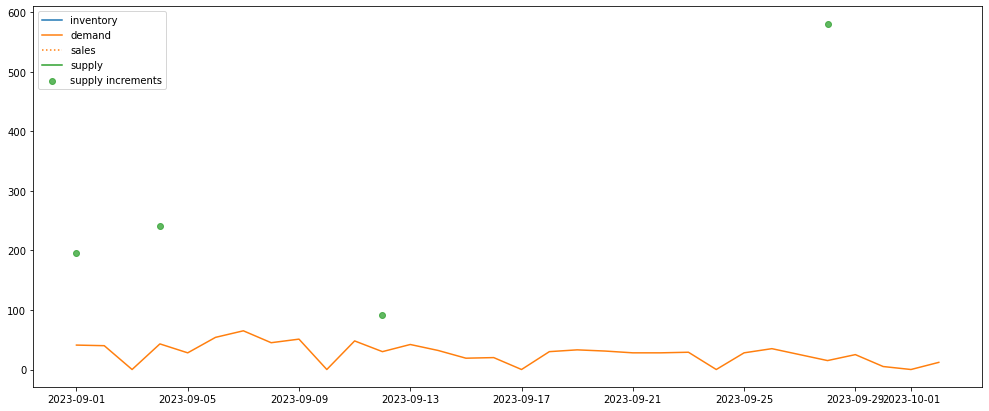

In [22]:
mpenv.plot()

> Demand and supply (increments) are known but should be considered as unknown when tackling this exercise. Sales and inventory will result from the actions taken.

Let's advance time with a couple of days. Default return is `(time, cost, end_of_available_data)`

In [23]:
[mpenv.step(0) for i in range(3)]

[(Timestamp('2023-09-02 00:00:00'), -10000.0, False, {}),
 (Timestamp('2023-09-03 00:00:00'), -0.0, False, {}),
 (Timestamp('2023-09-04 00:00:00'), -10750.0, False, {})]

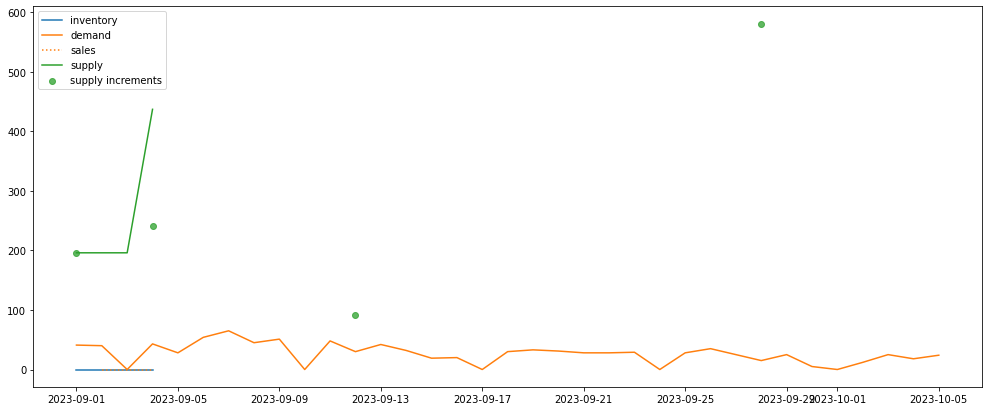

In [24]:
mpenv.plot()

> No inventory = missed sales = big understock costs

Let's resupply those shops with 2 units everywhere

In [25]:
mpenv.step(2)

(Timestamp('2023-09-05 00:00:00'), -7000.0, False, {})

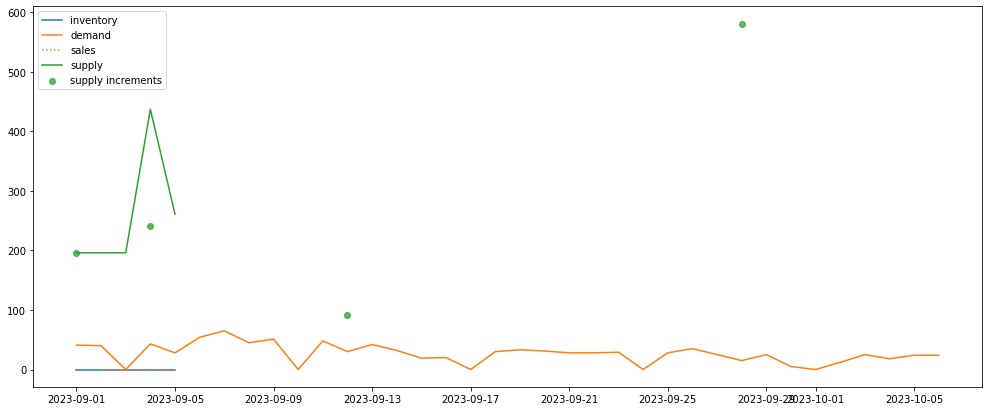

In [26]:
mpenv.plot()

> No inventory? We forgot to take into account the lead time of 2 days...

In [27]:
[mpenv.step(0) for i in range(2)]

[(Timestamp('2023-09-06 00:00:00'), -13500.0, False, {}),
 (Timestamp('2023-09-07 00:00:00'), -16250.0, False, {})]

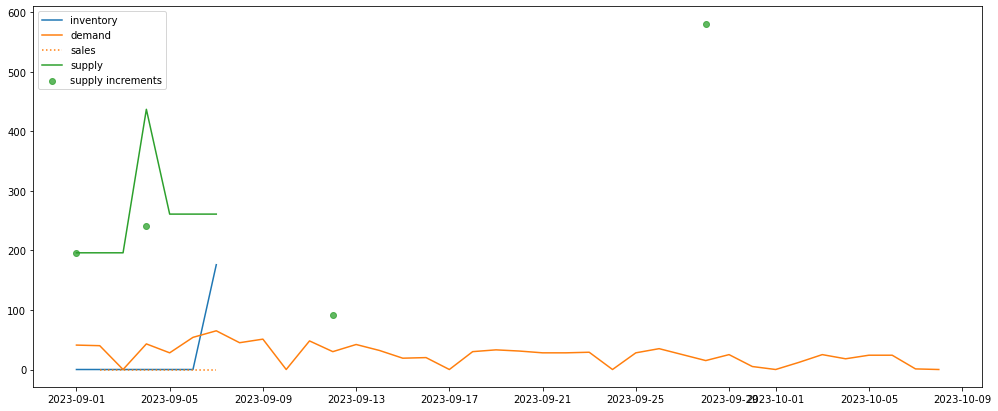

In [28]:
mpenv.plot()

> There we go, 2 units in 88 shops = 176 units of stock in total over all shops.

Let's advance time again and check the situation for 1 of the shops specifically.

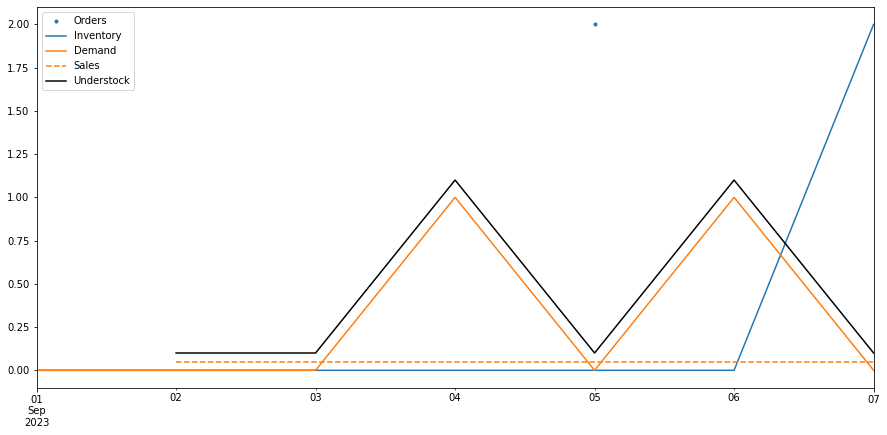

In [29]:
fig, ax = plt.subplots(figsize=(15, 7))
plant = mpenv.plants[0]
mpenv.read.ordr.loc[:, plant].replace(0, np.nan).plot(style=".", label='Orders')
mpenv.read.inv.loc[:, plant].plot(c='C0', label='Inventory')
mpenv.read.demand_dist.loc[:mpenv.index, plant].plot(label='Demand')
mpenv.read.sales.loc[:, plant].add(0.05).plot(c='C1', linestyle='--', label='Sales')
mpenv.read.understock.loc[:, plant].add(0.1).plot(c='black', label='Understock')
plt.legend()

ready launch=order supply, less restocking
launch=higher restocking that ready lunch
maturity, higher stock resuply
eol, less resuply

> A bit more code required here to plot the situation for a single shop, but still very doable to get to the bottom of the situation!

When taking actions you can input a range of actions, 1 for every shop. Let's resupply 1 unit to half the shops...

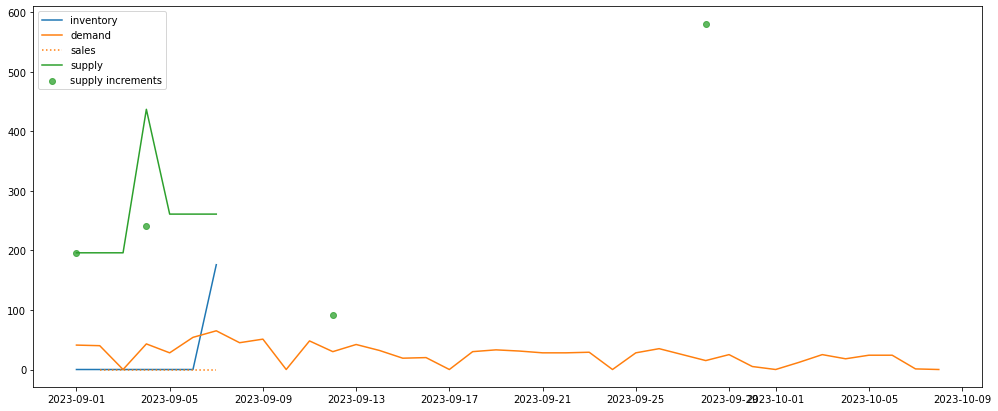

In [30]:
mpenv.plot()

In [31]:
size = mpenv.plants.size
action = np.append(np.repeat(1, size//2), np.repeat(0, size//2))
action

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
mpenv.step(action)

(Timestamp('2023-09-08 00:00:00'), -256.6, False, {})

In [33]:
[mpenv.step(0) for i in range(2)];

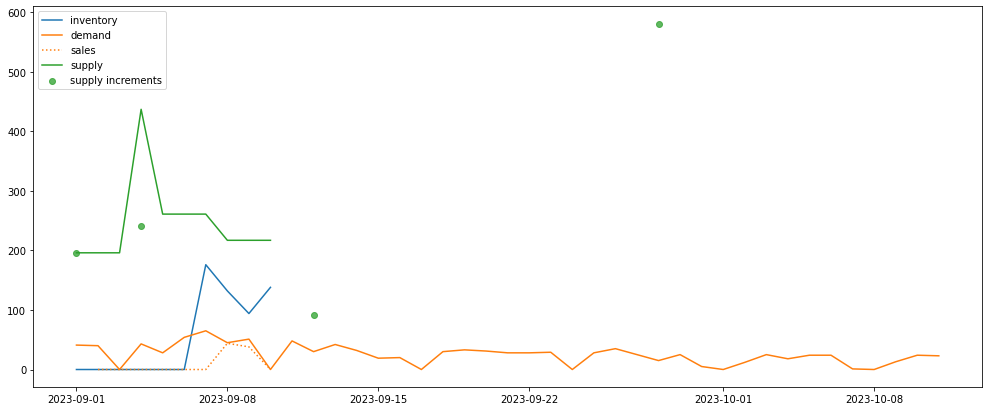

In [34]:
mpenv.plot()

In [35]:
print('Inventory increase =', int(mpenv.read.inv.sum(axis=1).iloc[-1]-mpenv.read.inv.sum(axis=1).iloc[-2]))
print('Half the number of shops =', size//2)

Inventory increase = 44
Half the number of shops = 44


> As expected, confirms our assumption visually and numerically.

> __Tip__: you can reset the environment to its starting situation with `env.reset()`

We can wrap this cycling between actions in a nice function, which will output the sum of costs, nice!

In [36]:
help(run_policied_env)

Help on function run_policied_env in module custom_objects:

run_policied_env(env, policy=None, params=None, render=False)
    Unfold (s)-environment with specified policy actions.
    
    Args:
        env: (Sampable) environment managing a simulations' evolution.
        policy: Distribution decision function. If None, uses the environment's transformer as policy.
        params: Parameters to the policy.        
        render: Whether to plot results or not.



But first we need a delivery policy ... maybe trigger a reorder of X units if the stock falls to 0.

In [37]:
mpenv.read.inv

,B124,B238,B319,B420,B534,B536,T101,T102,T103,T105,...,T754,T760,T772,T780,T782,T790,T791,T792,T794,T942
2023-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-07,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2023-09-08,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0,1.0,...,2.0,2.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0,2.0
2023-09-09,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,...,2.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,2.0
2023-09-10,2.0,2.0,1.0,2.0,3.0,1.0,2.0,1.0,2.0,1.0,...,2.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,2.0


In [38]:
mpenv.read.index

Timestamp('2023-09-10 00:00:00')

## Dummy Policy

In [39]:
# Orders up to level 1 when stock reaches 0
def dummy_policy(env, level):
    action = env.read.inv.loc[env.index].eq(0).astype(int).values * level
    return action

In [40]:
int(run_policied_env(mpenv, policy=dummy_policy, params=1, render=False))

-234537

> __Tip__: you can use `render=True` to plot the evolution 'live'. It'll take way more time though.

Let's try it for a couple of level values.

In [41]:
results = [int(run_policied_env(mpenv, policy=dummy_policy, params=i, render=False)) for i in range(5)]

-226856


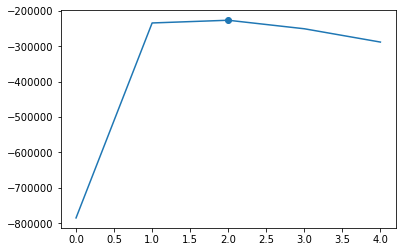

In [42]:
print(max(results))
plt.scatter(np.argmax(results), max(results))
plt.plot(results)

> There seems to be a trade-off... with an optimum at 2 units. The policy is still very reactive, let's try and make it a bit more anticipatory.

## Imporved Dummy Policy for Benchmark

In [43]:
## Dummy policy ordering up to various levels (to be optimised) when stock is less than or equal to 1
def dummy_policy(env, level):
    action = env.read.inv.loc[env.index].le(1).astype(int).values * level
    return action

In [44]:
results = [int(run_policied_env(mpenv, policy=dummy_policy, params=i, render=False)) for i in range(5)]

-197517


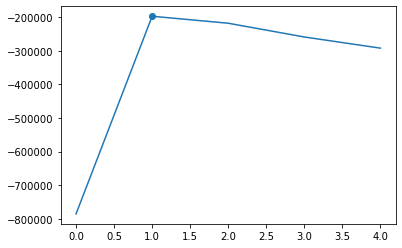

In [45]:
print(max(results))
plt.scatter(np.argmax(results), max(results))
plt.plot(results) 

> The result improved, but in proactive mode resupplying 2 units by default seem to be too much already.

## Demand anticipating policy

In [ ]:
# we use the iphone 14 to compare with benchmark

In [47]:
df_index = df.reset_index()

In [48]:
#define a function to retrieve the forecast of a material at a plant on a certain day
def get_daily_forecast(material, plant, date):
    try:
        # Attempt to get the 'Daily_forecast' value
        forecast = df_index[(df_index['Material'] == material) & (df_index['Plant'] == plant) & (df_index['Date'] == date)]['Daily_forecast'].iloc[0]
        return forecast
    except (IndexError, KeyError):
        # If an error occurs, return 0
        return 0

In [49]:
import datetime
def forecast_policy(env, level):
    material = 64640153 #We use the iPhone 14 so that we can compare to benchmark
    # create empty lists to store our values and do calculations
    forecast = []
    forecast_next_day = []
    forecast_next_day2 = []
    forecast_next_day3 = []
    inventory = []
    # retrieve all the dates needed to retrieve data from our previously defined function
    date = env.index
    next_day = env.index+timedelta(days=1) 
    next_day2 = env.index+timedelta(days=2) 
    next_day3 = env.index+timedelta(days=3)
    
    # Populate forecast arrays with the values from the dataframe for each plant
    for plant in mpenv.plants:
            daily_forecast = get_daily_forecast(material, plant, date)
            forecast.append(daily_forecast)
            daily_forecast = get_daily_forecast(material, plant, next_day)
            forecast_next_day.append(daily_forecast)
            daily_forecast = get_daily_forecast(material, plant, next_day2)
            forecast_next_day2.append(daily_forecast)
            daily_forecast = get_daily_forecast(material, plant, next_day3)
            forecast_next_day3.append(daily_forecast)
    
    inv = list(env.inv.values())[-1]
    forecast_array = np.array(forecast)

    #include boundry conditions (when we start the simulation) to retrieve order array
    if date == datetime.datetime(2023, 9, 1, 0, 0, 0) or date == datetime.datetime(2023, 9, 2, 0, 0, 0):
        ordr = [0] * 88
    else: 
        ordr = list(env.ordr.values())[-1]
    
    inv0 = inv-forecast #Calculate expected inventory at end of the day
    inv0[inv0 < 0] = 0 #make sure there are no negative inventory values

    #include boundry conditions (when we start the simulation) to retrieve previous day order array
    if date == datetime.datetime(2023, 9, 1, 0, 0, 0) or date == datetime.datetime(2023, 9, 2, 0, 0, 0):
        ordr_previous_day = 0
    else:
        previous_day = env.index+timedelta(days=-1)
        ordr_previous_day = list(env.ordr.values())[-2]
        
    #Calculate expected inventories at end of the each day during the lead time
    inv1 = inv0-forecast_next_day + ordr_previous_day
    inv1[inv1 < 0] = 0 #again making sure non-negative inventory values exist
    inv2 = inv1-forecast_next_day2 + ordr
    inv2[inv2 < 0] = 0
    inv3 = inv2-forecast_next_day3

    # we set a safety stock level that we aim to meet given expected inventory on the day our order will arrive
    treshold = level
    print(date)

    #set the action to order so that it meets the safety stock level on the day the order arrives
    action = treshold-inv3
    action[action < 0] = 0
    action = np.round(action) #actions must be integers
    
    return action

In [50]:
#We run our policy for different safety stock levels and see which level minimises cost
results = [int(run_policied_env(mpenv, policy=forecast_policy, params=i, render=False)) for i in range(0,3)]

2023-09-01 00:00:00
2023-09-02 00:00:00
2023-09-03 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-09 00:00:00
2023-09-10 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00
2023-09-16 00:00:00
2023-09-17 00:00:00
2023-09-18 00:00:00
2023-09-19 00:00:00
2023-09-20 00:00:00
2023-09-21 00:00:00
2023-09-22 00:00:00
2023-09-23 00:00:00
2023-09-24 00:00:00
2023-09-25 00:00:00
2023-09-26 00:00:00
2023-09-27 00:00:00
2023-09-28 00:00:00
2023-09-29 00:00:00
2023-09-30 00:00:00
2023-10-01 00:00:00
2023-10-02 00:00:00
2023-10-03 00:00:00
2023-10-04 00:00:00
2023-10-05 00:00:00
2023-10-06 00:00:00
2023-10-07 00:00:00
2023-10-08 00:00:00
2023-10-09 00:00:00
2023-10-10 00:00:00
2023-10-11 00:00:00
2023-10-12 00:00:00
2023-10-13 00:00:00
2023-10-14 00:00:00
2023-10-15 00:00:00
2023-10-16 00:00:00
2023-10-17 00:00:00
2023-10-18 00:00:00
2023-10-19 00:00:00
2023-10-20 00:00:00


-178372


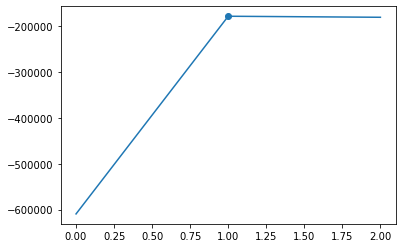

In [51]:
print(max(results))
plt.scatter(np.argmax(results), max(results))
plt.plot(results) 

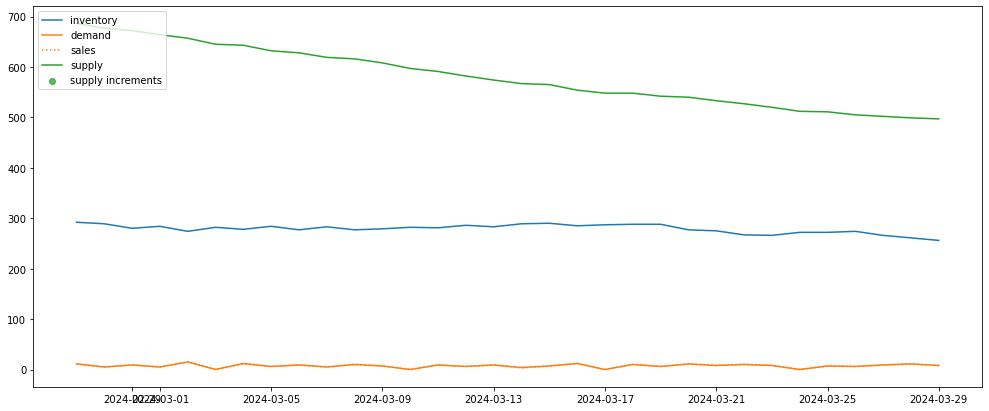

In [52]:
#Overview across all shops
mpenv.plot()

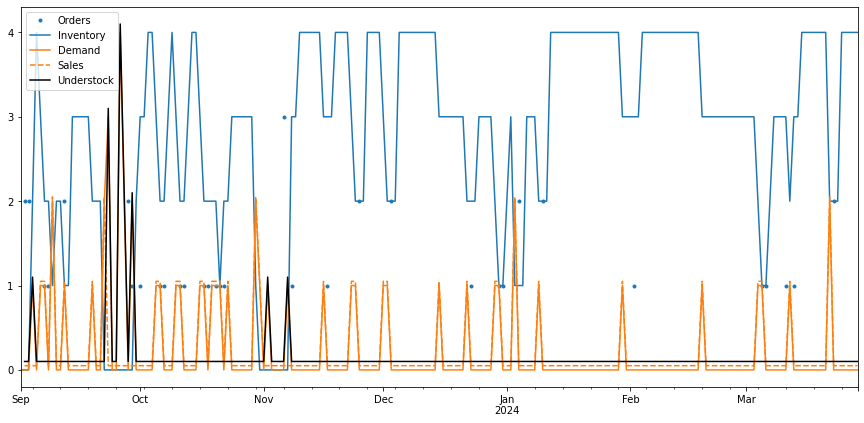

In [53]:
#for plant B319 we can check the behaviour of the policy
fig, ax = plt.subplots(figsize=(15, 7))
plant = mpenv.plants[2]
mpenv.read.ordr.loc[:, plant].replace(0, np.nan).plot(style=".", label='Orders')
mpenv.read.inv.loc[:, plant].plot(c='C0', label='Inventory')
mpenv.read.demand_dist.loc[:mpenv.index, plant].plot(label='Demand')
mpenv.read.sales.loc[:, plant].add(0.05).plot(c='C1', linestyle='--', label='Sales')
mpenv.read.understock.loc[:, plant].add(0.1).plot(c='black', label='Understock')
plt.legend()

## Including the improved forecast with Sarima and Bass diffusion

In [200]:
!pwd

/home/jovyan/vlerick


In [256]:
#Retrieve our improved forecasted values from the modelling notebook
df2 = pd.read_csv('/home/jovyan/vlerick/Forecast_64640153.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2

,Material,Plant,Date,Description,Type,Supply,Demand,Price,Status,Current_month_forecast,Daily_forecast,Hist_method,Hist_activity,Hist_shop_stock,Hist_supplier_stock,Hist_sales,Volume,Our Forecast
0,64640153,B124,2023-09-01,iPhone 14 128GB Midnight,Mobile,196.0,0.0,1019.99,Maturity,600.0,0.36,AUTO,14.12,2.0,0.0,0,0.00,0.227484
1,64640153,B124,2023-09-02,iPhone 14 128GB Midnight,Mobile,0.0,0.0,1019.99,Maturity,600.0,0.36,AUTO,14.12,2.0,0.0,0,0.00,0.220632
2,64640153,B124,2023-09-03,iPhone 14 128GB Midnight,Mobile,0.0,0.0,1019.99,Maturity,600.0,0.36,AUTO,14.12,2.0,0.0,0,0.00,0.219510
3,64640153,B124,2023-09-04,iPhone 14 128GB Midnight,Mobile,241.0,1.0,1019.99,Maturity,600.0,0.33,AUTO,14.52,2.0,0.0,1,1019.99,0.207243
4,64640153,B124,2023-09-05,iPhone 14 128GB Midnight,Mobile,0.0,0.0,1019.99,Maturity,600.0,0.34,AUTO,13.64,3.0,0.0,0,0.00,0.246413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17677,64640153,T942,2024-03-25,iPhone 14 128GB Midnight,Mobile,0.0,0.0,819.99,Maturity,250.0,0.11,AUTO,15.84,2.0,381.0,0,0.00,0.015821
17678,64640153,T942,2024-03-26,iPhone 14 128GB Midnight,Mobile,0.0,0.0,819.99,Maturity,250.0,0.11,MANUAL,15.80,2.0,373.0,0,0.00,0.381283
17679,64640153,T942,2024-03-27,iPhone 14 128GB Midnight,Mobile,0.0,0.0,819.99,Maturity,250.0,0.11,MANUAL,15.19,4.0,366.0,0,0.00,0.300672
17680,64640153,T942,2024-03-28,iPhone 14 128GB Midnight,Mobile,0.0,0.0,819.99,Maturity,250.0,0.11,MANUAL,14.73,4.0,362.0,0,0.00,0.019388


In [260]:
#defining a function that retrieve our improved forecating figures instead of the given forecast
def get_our_daily_forecast(material, plant, date):
    try:
        # Attempt to get the 'Our Forecast' value
        forecast = df2[(df2['Material'] == material) & (df2['Plant'] == plant) & (df2['Date'] == date)]['Our Forecast'].iloc[0]
        return forecast
    except (IndexError, KeyError):
        # If an error occurs, return 0
        return 0

In [265]:
def our_forecast_policy(env, level):
    material = 64640153 #to check against benchmark
    forecast = []
    forecast_next_day = []
    forecast_next_day2 = []
    forecast_next_day3 = []
    inventory = []
    date = env.index
    next_day = env.index+timedelta(days=1)
    next_day2 = env.index+timedelta(days=2)
    next_day3 = env.index+timedelta(days=3)
    
    
    for plant in mpenv.plants:
            daily_forecast = get_our_daily_forecast(material, plant, date)
            forecast.append(daily_forecast)
            daily_forecast = get_our_daily_forecast(material, plant, next_day)
            forecast_next_day.append(daily_forecast)
            daily_forecast = get_our_daily_forecast(material, plant, next_day2)
            forecast_next_day2.append(daily_forecast)
            daily_forecast = get_our_daily_forecast(material, plant, next_day3)
            forecast_next_day3.append(daily_forecast)
    
    inv = list(env.inv.values())[-1]
    forecast_array = np.array(forecast)
    if date == datetime.datetime(2023, 9, 1, 0, 0, 0) or date == datetime.datetime(2023, 9, 2, 0, 0, 0):
        ordr = [0] * 88
        
        
    else: 
        ordr = list(env.ordr.values())[-1]
    
    inv0 = inv-forecast
    inv0[inv0 < 0] = 0
    if date == datetime.datetime(2023, 9, 1, 0, 0, 0) or date == datetime.datetime(2023, 9, 2, 0, 0, 0):
        ordr_previous_day = 0
    
    else:
        previous_day = env.index+timedelta(days=-1)
        #ordr_previous_day = env.ordr[previous_day]
        ordr_previous_day = list(env.ordr.values())[-2]
        
        
    inv1 = inv0-forecast_next_day + ordr_previous_day
    inv1[inv1 < 0] = 0
    inv2 = inv1-forecast_next_day2 + ordr
    inv2[inv2 < 0] = 0
    inv3 = inv2-forecast_next_day3
    
    treshold = level
    print(date)

    action = treshold-inv3
    action[action < 0] = 0
    action = np.round(action)

    
    return action

In [267]:
#Run for different safety stock levels to find optimal
results = [int(run_policied_env(mpenv, policy=our_forecast_policy, params=i, render=False)) for i in range(0,4)]

/home/jovyan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/home/jovyan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less
/home/jovyan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less
/home/jovyan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/home/jovyan/vlerick/custom_objects.py:379: RuntimeWarning: invalid value encountered in greater
/home/jovyan/vlerick/custom_objects.py:380: RuntimeWarning: invalid value encountered in greater


2023-09-01 00:00:00
2023-09-02 00:00:00
2023-09-03 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-09 00:00:00
2023-09-10 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00
2023-09-16 00:00:00
2023-09-17 00:00:00
2023-09-18 00:00:00
2023-09-19 00:00:00
2023-09-20 00:00:00
2023-09-21 00:00:00
2023-09-22 00:00:00
2023-09-23 00:00:00
2023-09-24 00:00:00
2023-09-25 00:00:00
2023-09-26 00:00:00
2023-09-27 00:00:00
2023-09-28 00:00:00
2023-09-29 00:00:00
2023-09-30 00:00:00
2023-10-01 00:00:00
2023-10-02 00:00:00
2023-10-03 00:00:00
2023-10-04 00:00:00
2023-10-05 00:00:00
2023-10-06 00:00:00
2023-10-07 00:00:00
2023-10-08 00:00:00
2023-10-09 00:00:00
2023-10-10 00:00:00
2023-10-11 00:00:00
2023-10-12 00:00:00
2023-10-13 00:00:00
2023-10-14 00:00:00
2023-10-15 00:00:00
2023-10-16 00:00:00
2023-10-17 00:00:00
2023-10-18 00:00:00
2023-10-19 00:00:00
2023-10-20 00:00:00


-86935


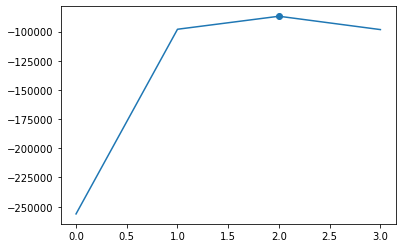

In [268]:
print(max(results))
plt.scatter(np.argmax(results), max(results))
plt.plot(results) 

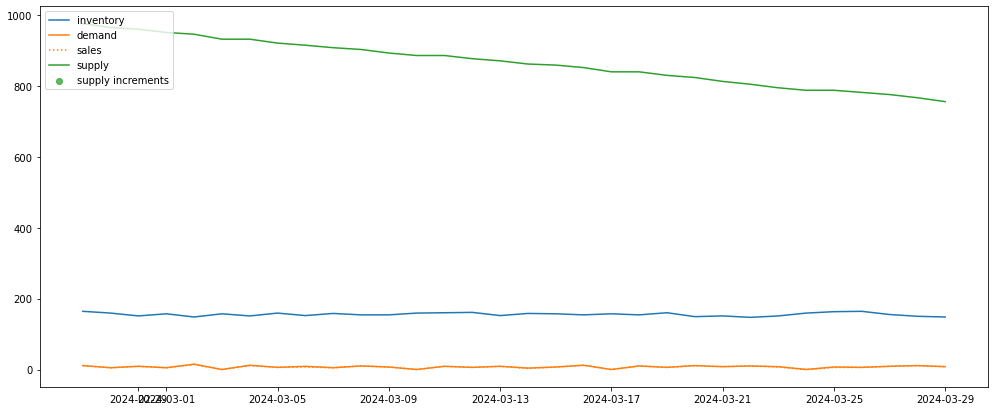

In [230]:
mpenv.plot()

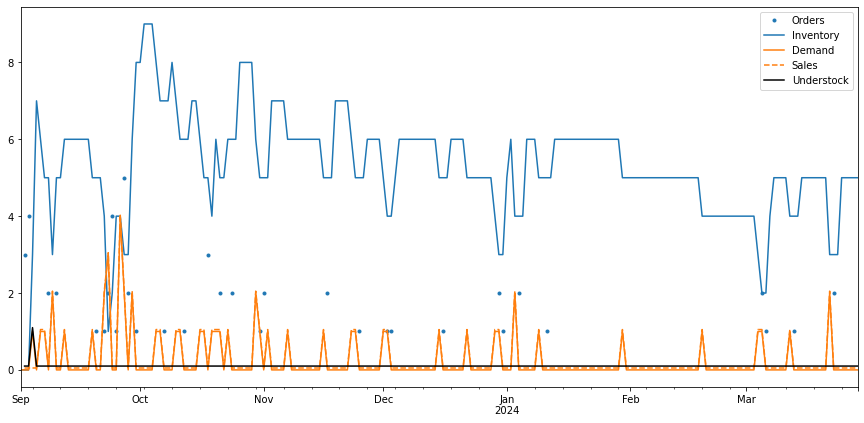

In [278]:
#We plot for plant B319 to check the behaviour compared to the previous policy
fig, ax = plt.subplots(figsize=(15, 7))
plant = mpenv.plants[2]
mpenv.read.ordr.loc[:, plant].replace(0, np.nan).plot(style=".", label='Orders')
mpenv.read.inv.loc[:, plant].plot(c='C0', label='Inventory')
mpenv.read.demand_dist.loc[:mpenv.index, plant].plot(label='Demand')
mpenv.read.sales.loc[:, plant].add(0.05).plot(c='C1', linestyle='--', label='Sales')
mpenv.read.understock.loc[:, plant].add(0.1).plot(c='black', label='Understock')
plt.legend()

In [ ]:
# This policy with the improved forecast performs much better than the old forecast
# these policy can be run for all products and the new forecasted figures to retrieve the optimal safety stock levels
# compute time restricted us in running the policy for all materials but the concept stays ecxactly the same